In [5]:
# %matplotlib widget
import numpy as np
import yfinance as yf
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd


# Set up


In [6]:
START = "2020-01-01"
END = "2025-01-01"
TICKER = "^GSPC"
TITLE = TICKER + " - " +(datetime.now()).strftime("%Y-%m-%d - %H:%M:%S")

In [7]:
data = yf.download(TICKER, start=START, end=END,multi_level_index=False)

data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))

[*********************100%***********************]  1 of 1 completed


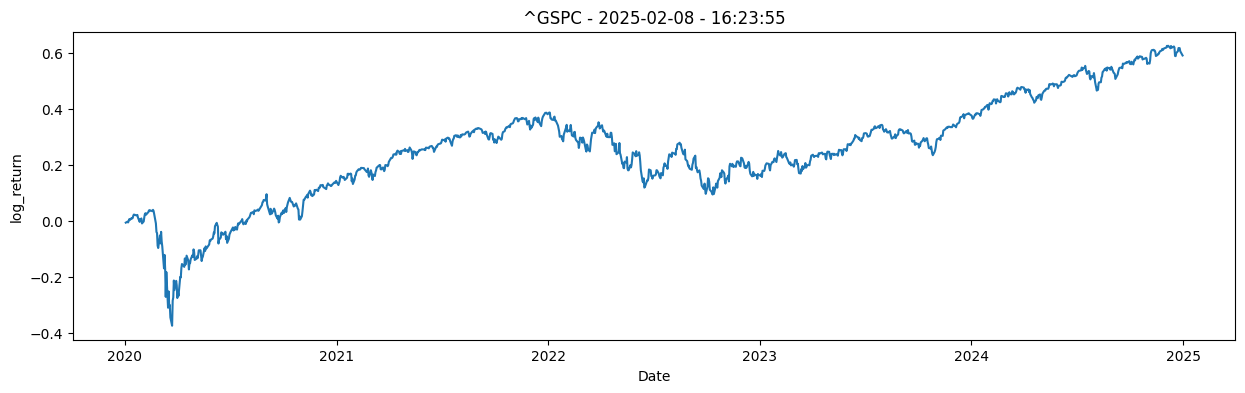

In [8]:
fig = plt.figure(figsize=(15,4))
sns.lineplot(data["log_return"].cumsum()).set_title(TITLE)
plt.show()

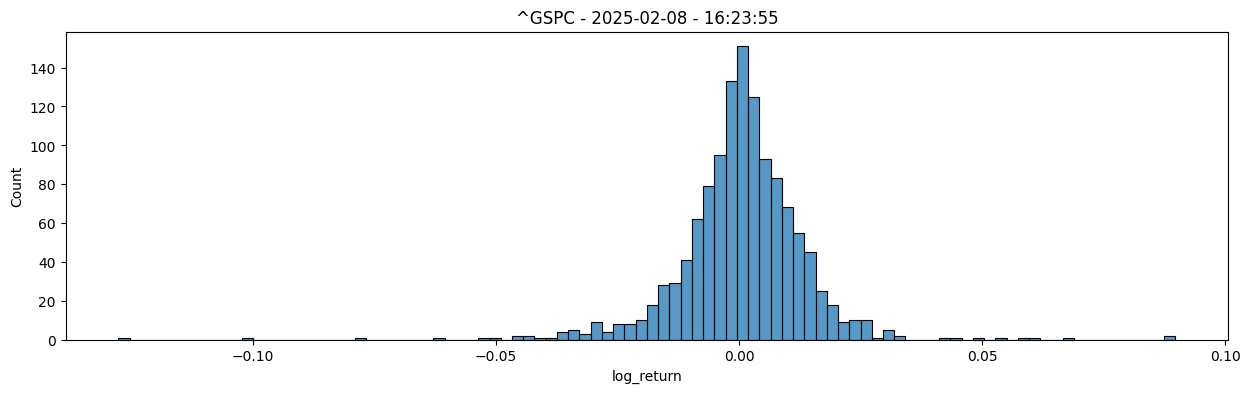

In [9]:
fig = plt.figure(figsize=(15,4))
sns.histplot(data["log_return"]).set_title(TITLE)
plt.show()

## SMA

In [10]:
def sma(data, t):
    return data.shift(1).rolling(t).mean()

In [11]:
data["SMA_fast"] = sma(data["Close"],20)
data["SMA_slow"] = sma(data["Close"],50)
data["SMA_long"] = sma(data["Close"],200)

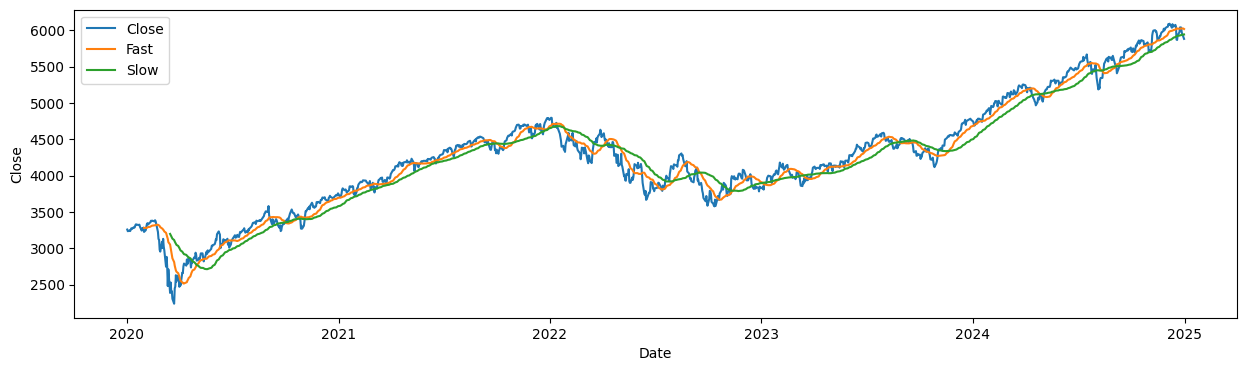

In [12]:
fig = plt.figure(figsize=(15,4))
ax1 = sns.lineplot(data["Close"],label="Close")
ax2 = sns.lineplot(data["SMA_fast"],label="Fast")
ax3 = sns.lineplot(data["SMA_slow"],label="Slow")
plt.legend()
plt.show()

In [13]:
data["bull"] = data["SMA_fast"] > data["SMA_slow"]
data

,Close,High,Low,Open,Volume,log_return,SMA_fast,SMA_slow,SMA_long,bull
Date,,,,,,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000,NaN,NaN,NaN,NaN,False
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000,-0.007085,NaN,NaN,NaN,False
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000,0.003527,NaN,NaN,NaN,False
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000,-0.002807,NaN,NaN,NaN,False
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000,0.004890,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,0.010982,6021.608008,5930.204404,5531.060852,True
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000,-0.000406,6024.241504,5933.808203,5535.671353,True
2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3159610000,-0.011117,6025.039502,5938.254805,5539.982952,True


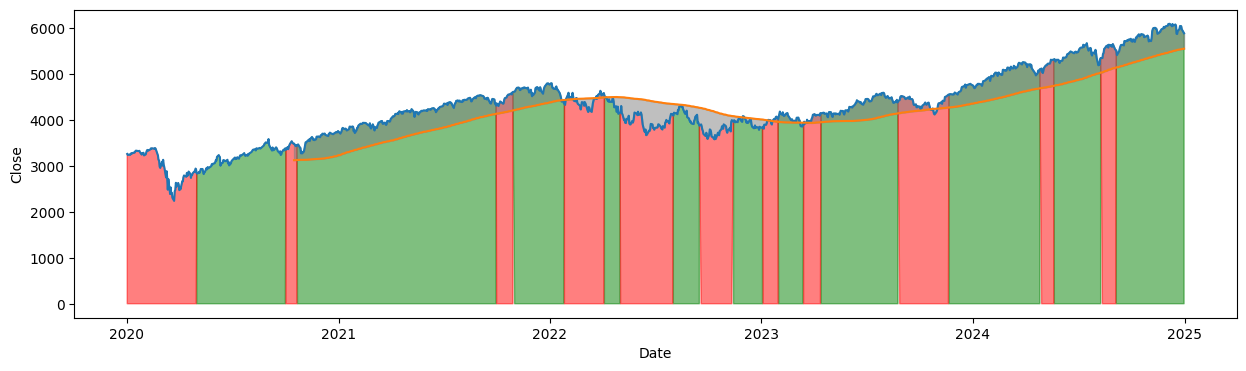

In [14]:
fig = plt.figure(figsize=(15,4))
plt.fill_between(data.index, data["Close"], 0, where=data["bull"],color="green",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], 0, where=~data["bull"],color="red",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], data["SMA_long"],color="grey",alpha=0.5,interpolate=True)
ax1 = sns.lineplot(data["Close"])
ax1 = sns.lineplot(data["SMA_long"])
plt.show()

# Bull and bear markets

<Axes: xlabel='log_return', ylabel='Count'>

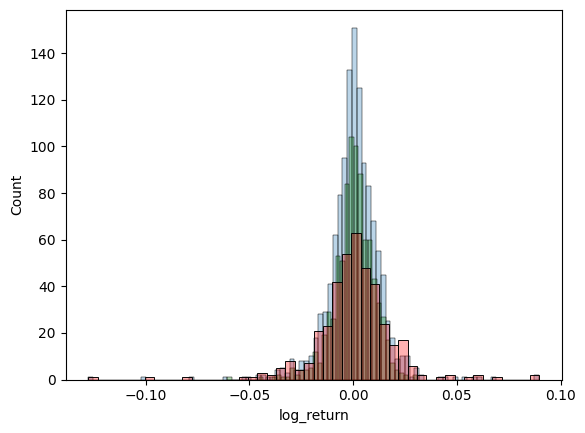

In [15]:
sns.histplot(data["log_return"],alpha=0.3)
sns.histplot(data["log_return"].where(data["bull"]),color="green",alpha=0.3)
sns.histplot(data["log_return"].where(~data["bull"]),color="red",alpha=0.3)

## 1 - Normality testing

In [28]:
import scipy.stats as stt

In [69]:
def jarque_bera(data):
    return f"{stt.jarque_bera(data).pvalue:.2f}"

def normaltest(data):
    return f"{stt.normaltest(data).pvalue:.2f}"

### 1.1 - Normal testing - All returns

In [70]:
jarque_bera(data["log_return"].dropna())

'0.00'

In [71]:
normaltest(data["log_return"].dropna())

'0.00'

### 1.2 - Normal testing - Bull and bear

In [72]:
# Bull
jarque_bera(data["log_return"].where(data["bull"]).dropna())

'0.00'

In [73]:
# Bear
jarque_bera(data["log_return"].where(~data["bull"]).dropna())

'0.00'

# Back testing

In [74]:
# Date, Buy, Balance, Position
last = 0
equity = [(data.index[0],0,10_000,0)]
for index, row in data.iterrows():

    buy = 0
    position = equity[-1][3]
    balance = equity[-1][2]
    if row["bull"] and not last: # Buy
        buy = 1
        position = balance // row["Open"]
        balance -= row["Open"] * position

    if not row["bull"] and last: # Sell
        buy = -1
        balance += row["Open"] * position
        position = 0

    equity.append((index, buy, balance, position))
    last = row["bull"]

equity = pd.DataFrame(equity,columns=["Date","buy","balance","position"])

equity = equity.set_index("Date")

data = data.join(equity)

data["value"] = (data["position"] * data["Close"]) + data["balance"]

ValueError: columns overlap but no suffix specified: Index(['buy', 'balance', 'position'], dtype='object')

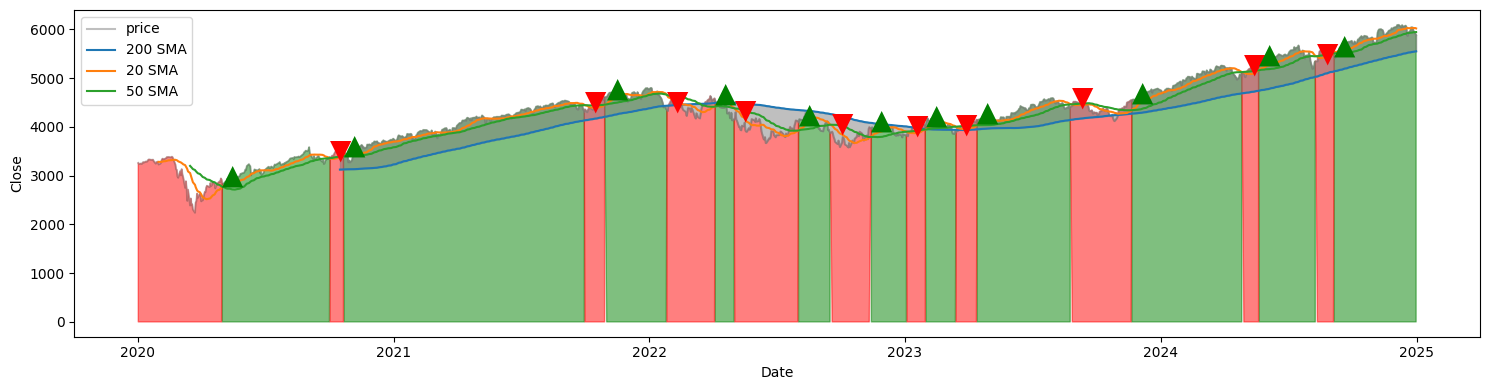

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,4))

plt.fill_between(data.index, data["Close"], 0, where=data["bull"],color="green",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], 0, where=~data["bull"],color="red",alpha=0.5,interpolate=True)
plt.fill_between(data.index, data["Close"], data["SMA_long"],color="grey",alpha=0.5,interpolate=True)

ax1 = sns.lineplot(data["Close"],color="grey",alpha=0.5, label="price")
ax1 = sns.lineplot(data["SMA_long"],label="200 SMA")
ax1 = sns.lineplot(data["SMA_fast"], label="20 SMA")
ax1 = sns.lineplot(data["SMA_slow"], label="50 SMA")
# sns.lineplot(data["value"])

df_filt = data[data["buy"] != 0.0]

for index, value in df_filt.iterrows():
    if value["buy"] == -1.0:
        ax1.annotate("▼",(index,value["Close"]), color="red",fontsize=20)
    if value["buy"] == 1.0:
        ax1.annotate("▲",(index,value["Close"]), color="green",fontsize=20)

fig.tight_layout()

plt.show()

In [ ]:
# data.to_excel("test.xlsx")

In [ ]:
data["log_return"].sum()

np.float64(0.5907664158747504)

In [ ]:
data["value_log_return"] = np.log((data["value"] / data["value"].shift(1)))

data["value_log_return"].sum()

np.float64(0.32492860449233496)

<Axes: xlabel='Date', ylabel='log_return'>

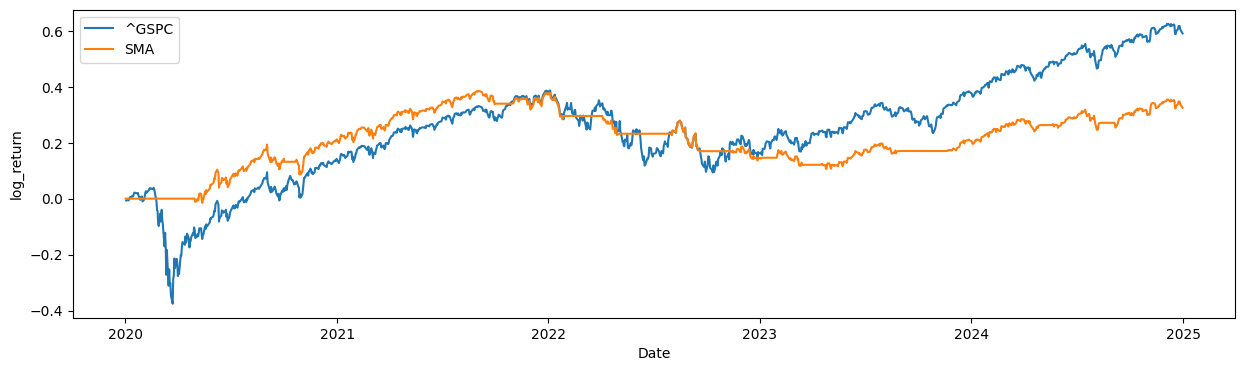

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,4))
sns.lineplot(data["log_return"].cumsum(),dashes=False,label=[TICKER])
sns.lineplot(data["value_log_return"].cumsum(),dashes=False,label=["SMA"])

In [ ]:
data["log_return"].std()

np.float64(0.013499665985841673)

In [ ]:
data["value_log_return"].std()

np.float64(0.00681599820004336)

In [ ]:
(data["log_return"].sum() / data["log_return"].std()) / 5

np.float64(8.752311597847545)

In [ ]:
(data["value_log_return"].sum() / data["value_log_return"].std())/ 5

np.float64(9.534292555718924)